In [1]:
%load_ext autoreload
%autoreload 2
from imports.networks import *
from imports.data import *
from imports.params import p
import matplotlib.pyplot as plt

In [2]:
sw_path = "flamingo_0077/flamingo_0077.hdf5"
data = Data(p, sw_path=sw_path)
filename = p_to_filename(p) + "big2"
# filename = "obs_data_L1000N1800_HYDRO_FIDUCIAL_SO_500crit_res64_M1e13_rad2Mpc"
data.make_nn_dataset(filename=filename, target="TotalMass")
data.load_testset(filename=filename)
# indices = np.load(f"{p['data_path']}{filename}_halo_indices.npy")[data.shuffled_indices]
# images = np.load(f"{p['data_path']}{filename}.npy")[data.shuffled_indices]
# images = images[:int(len(indices)*p["test_size"])]
# masses = data.soap_file[f"{data.selection_type}/TotalMass"][()][indices]
# masses = masses[:int(len(indices)*p["test_size"])]
resolution = p['resolution']

# difference plots 14 nov


In [3]:
nnmodel = torch.load(f"{p['model_path']}/obs_model_2chan_best.pt", map_location=torch.device("cpu"))
nnmodel_low = torch.load(f"{p['model_path']}/obs_model_low_best.pt", map_location=torch.device("cpu"))
nnmodel_high = torch.load(f"{p['model_path']}/obs_model_high_best.pt", map_location=torch.device("cpu"))
spl_low = np.load(f"{p['model_path']}/spline_fit_low.npy", allow_pickle=True)[()]
spl_high = np.load(f"{p['model_path']}/spline_fit_high.npy", allow_pickle=True)[()]

# predictions = np.ndarray((len(data.images), 5))
predictions = np.ndarray((len(data.testy), 5))

#predict with NN
with torch.no_grad():
    predictions[:, 0] = 10**(nnmodel(torch.Tensor(data.testx)).squeeze(1) * data.std_y + data.mean_y)
    predictions[:, 1] = 10**(nnmodel_low(torch.Tensor(data.testx[:,0,:,:].reshape(len(data.testy), 1, 64, 64))).squeeze(1) * data.std_y + data.mean_y)
    predictions[:, 2] = 10**(nnmodel_high(torch.Tensor(data.testx[:,1,:,:].reshape(len(data.testy), 1, 64, 64))).squeeze(1) * data.std_y + data.mean_y)

In [4]:
pixel_size = 4 * 1000 / 64  #kpc
radii = []
for i, haloindex in enumerate(data.indices):
    r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
    radius = r / pixel_size
    radii.append(radius)
    X, Y = np.ogrid[:resolution, :resolution]
    dist_from_center = np.sqrt((X + 0.5-int(resolution/2))**2+(Y+0.5-int(resolution/2))**2)
    mask_outer = dist_from_center<=radius
    mask_inner = dist_from_center<=(radius-1)
    luminosity_circle_low = np.log10(np.sum(data.images[i, 0][mask_outer]))
    luminosity_circle_high = np.log10(np.sum(data.images[i, 1][mask_outer]))
    predictions[i,3] = 10**spl_low(luminosity_circle_low)
    predictions[i,4] = 10**spl_high(luminosity_circle_high)

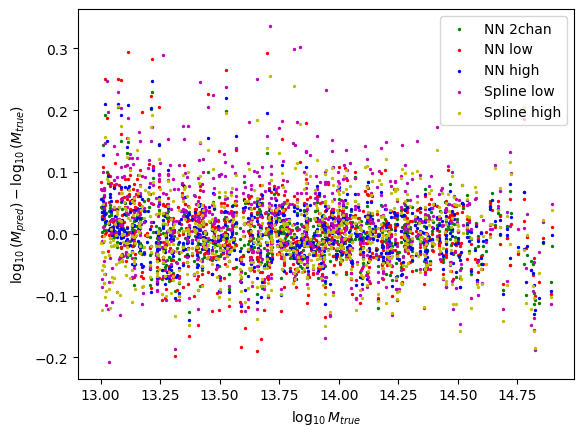

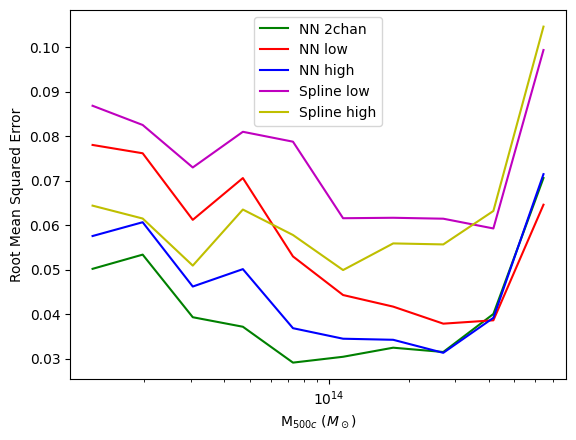

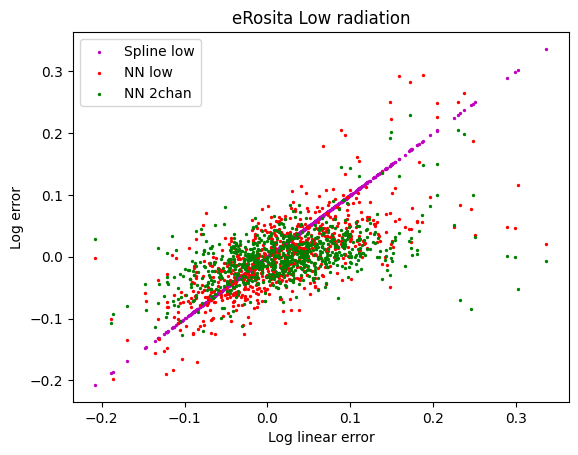

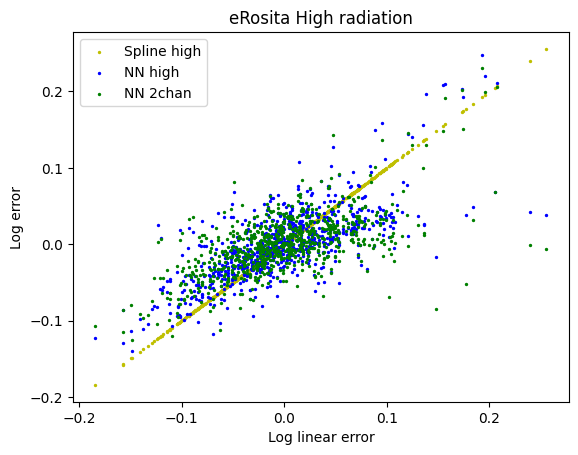

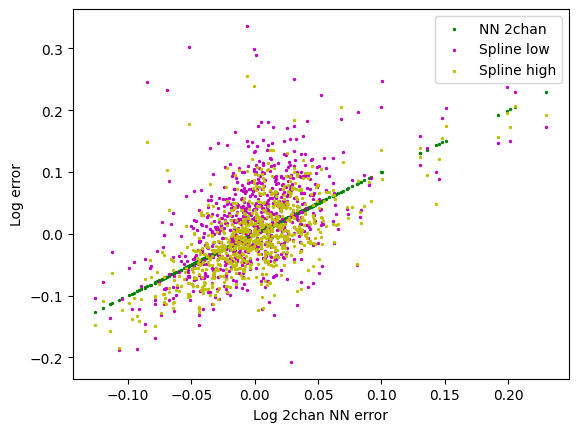

In [6]:
names = ["NN 2chan", "NN low", "NN high", "Spline low", "Spline high"]
colors = ["green", "red", "blue", "m", "y"]


for i in range(0, 5):
    plt.scatter(np.log10(data.masses), np.log10(predictions[:,i]) - np.log10(data.masses), label=names[i], color=colors[i], s=2)
plt.ylabel("$\log_{10}(M_{pred}) - \log_{10}(M_{true})$")
plt.xlabel("$\log_{10} M_{true}$")
plt.legend()
plt.savefig("Error 19 dec", dpi=300)
plt.show()


for i in range(0, 5):
    nr_bins = 10
    x = np.array([])
    y = np.array([])
    bin_edges = np.logspace(np.log10(np.min(data.masses)), np.log10(np.max(data.masses)), nr_bins+1)
    minspread = np.array([])
    maxspread = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(data.masses > bin_edges[b], data.masses < bin_edges[b+1])
        x = np.append(x, np.mean([bin_edges[b], bin_edges[b+1]]))
        y = np.append(y, np.sqrt(np.mean((np.log10(predictions[indices,i]) - np.log10(data.masses[indices]))**2)))
    plt.plot(x, y, label=names[i], color=colors[i])
# plt.hlines(0.0, np.min(data.masses), np.max(data.masses), colors="black", linestyles="dashed", alpha=0.8)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("M$_{500c}$ $(M_\odot)$")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.savefig("RMSE 19 dec", dpi=300)
plt.show()


low_error = np.log10(predictions[:,3]) - np.log10(data.masses)
plt.scatter(low_error, np.log10(predictions[:,3]) - np.log10(data.masses), label=names[3], c=colors[3], s=2)
plt.scatter(low_error, np.log10(predictions[:,1]) - np.log10(data.masses), label=names[1], c=colors[1], s=2)
plt.scatter(low_error, np.log10(predictions[:,0]) - np.log10(data.masses), label=names[0], c=colors[0], s=2)

# plt.hlines(0.0, np.min(data.masses), np.max(data.masses), colors="black", linestyles="dashed", alpha=0.8)
plt.xlabel("Log linear error")
plt.ylabel("Log error")
plt.title("eRosita Low radiation")
plt.legend()
plt.show()

plt.scatter(np.log10(predictions[:,4]) - np.log10(data.masses), np.log10(predictions[:,4]) - np.log10(data.masses), label=names[4], c=colors[4], s=2)
plt.scatter(np.log10(predictions[:,4]) - np.log10(data.masses), np.log10(predictions[:,2]) - np.log10(data.masses), label=names[2], c=colors[2], s=2)
plt.scatter(np.log10(predictions[:,4]) - np.log10(data.masses), np.log10(predictions[:,0]) - np.log10(data.masses), label=names[0], c=colors[0], s=2)
plt.xlabel("Log linear error")
plt.ylabel("Log error")
plt.title("eRosita High radiation")
plt.legend()
plt.show()


plt.scatter(np.log10(predictions[:,0]) - np.log10(data.masses), np.log10(predictions[:,0]) - np.log10(data.masses), label=names[0], c=colors[0], s=2)
# plt.scatter(np.log10(predictions[:,0]) - np.log10(data.masses), np.log10(predictions[:,1]) - np.log10(data.masses), label=names[1], c=colors[1], s=2)
# plt.scatter(np.log10(predictions[:,0]) - np.log10(data.masses), np.log10(predictions[:,2]) - np.log10(data.masses), label=names[2], c=colors[2], s=2)
plt.scatter(np.log10(predictions[:,0]) - np.log10(data.masses), np.log10(predictions[:,3]) - np.log10(data.masses), label=names[3], c=colors[3], s=2)
plt.scatter(np.log10(predictions[:,0]) - np.log10(data.masses), np.log10(predictions[:,4]) - np.log10(data.masses), label=names[4], c=colors[4], s=2)
plt.xlabel("Log 2chan NN error")
plt.ylabel("Log error")
# plt.title("eRosita Low radiation")
plt.legend()
plt.show()


[-0.24731446 -0.14384747 -0.11290742 -0.09025383 -0.08607387 -0.0734625
 -0.07245542 -0.06517983 -0.06362344 -0.03210067 -0.02991772 -0.02373696
 -0.01521681  0.08068372]
5134042
[44.36102482 44.27130419 44.2001508 ]


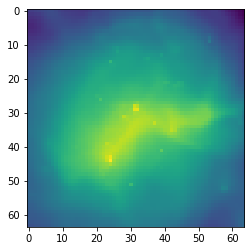

In [73]:
errors = (np.log10(predictions[:,1]) - np.log10(data.masses))[data.masses > 10**(14.75)] #errors
error = errors[np.argmin(errors)]
ids = np.argsort(errors)
print(errors[ids])
print(data.indices[ids[0]])
print(np.log10(data.soap_file["SO/500_crit/XRayLuminosity"][data.indices[data.masses > 10**(14.75)][ids[0]]]))

plt.imshow(np.log10(data.images[data.masses > 10**(14.75)][ids[0], 0]))
plt.show()

[511.12029945 513.50939945 300.09884945]
[511.13891198 513.51318198 300.08858198]
0.39746094
0.054321348393760516


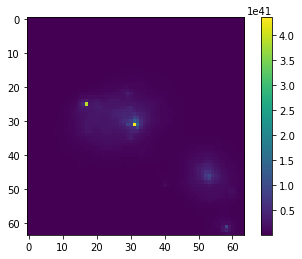

In [43]:
i = 501
halo = data.indices[i]
print(data.soap_file["SO/500_crit/CentreOfMass"][halo])
print(data.soap_file["VR/CentreOfPotential"][halo])
print(data.soap_file["SO/500_crit/SORadius"][halo])
print(np.linalg.norm(data.soap_file["SO/500_crit/CentreOfMass"][halo] - data.soap_file["VR/CentreOfPotential"][halo])/data.soap_file["SO/500_crit/SORadius"][halo])
plt.imshow((data.images[i, 0]))
plt.colorbar()

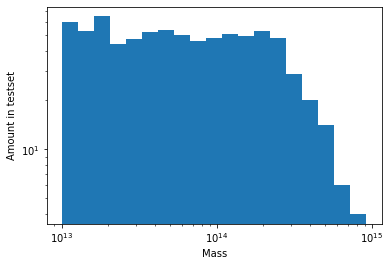

In [89]:
bins = np.logspace(np.min(np.log10(data.masses)), np.max(np.log10(data.masses)), 20)
plt.hist(data.masses, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Mass")
plt.ylabel("Amount in testset")
plt.show()

101072


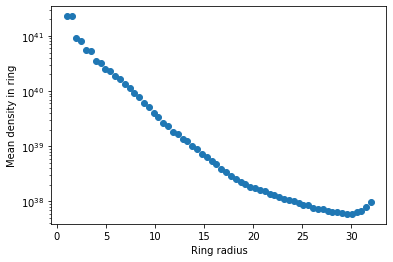

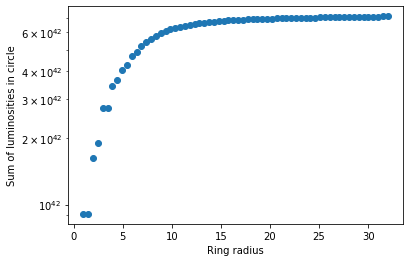

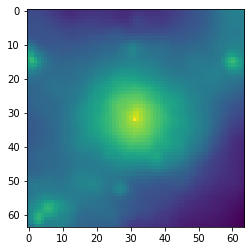

101073


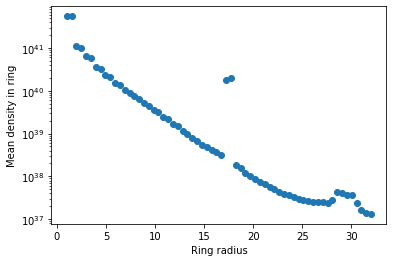

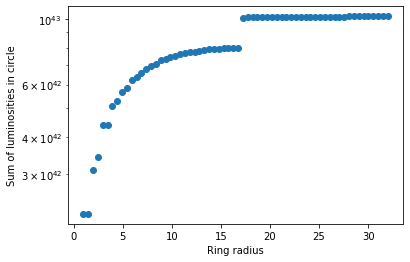

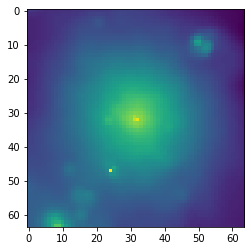

101221


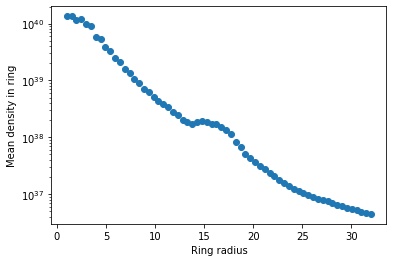

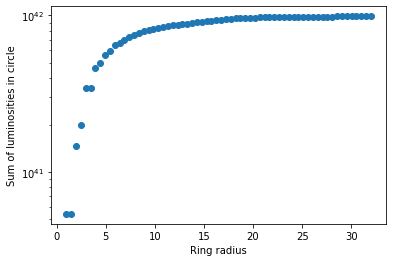

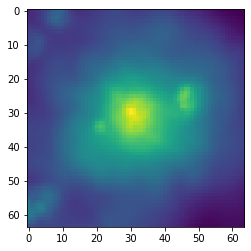

In [29]:
for i in range(23, 26):
    print(np.load(f"{filepath}_halo_indices.npy")[i])
    ringdensities = []
    circlesum = []
    radii = []
    for radius in np.linspace(1, resolution/2, resolution):
        X, Y = np.ogrid[:resolution, :resolution]
        dist_from_center = np.sqrt((X + 0.5-int(resolution/2))**2+(Y+0.5-int(resolution/2))**2)
        mask_outer = dist_from_center<=radius
        mask_inner = dist_from_center<=(radius-1)
        ringdensities.append(np.mean(images[i,0][mask_outer != mask_inner]))
        circlesum.append(np.sum(images[i, 0][mask_outer]))
        radii.append(radius)
        # plt.imsindices_yhow(mask_outer != mask_inner)
        # plt.show()
    plt.scatter(radii, ringdensities)
    plt.xlabel("Ring radius")
    plt.ylabel("Mean density in ring")
    plt.yscale("log")
    plt.show()

    plt.scatter(radii, circlesum)
    plt.xlabel("Ring radius")
    plt.ylabel("Sum of luminosities in circle")
    plt.yscale("log")
    plt.show()

    plt.imshow(np.log10(images[i,0]))
    plt.show()

In [20]:
rhocrit = 10**-26 * unyt.kg / unyt.m**3
print((1*unyt.kpc).in_units(unyt.m))
print(rhocrit.in_units(unyt.Msun / unyt.kpc**3) * 500)
print(densities/(data.soap_file[f"{data.selection_type}/SORadius"][np.load(f"{filepath}_halo_indices.npy")][0]*unyt.Mpc).in_units(unyt.kpc))
# print(densities/)

3.085677580962325e+19 m
1.4689994722925896e+35 kg/kpc**3
[4.24400258e+39 4.24400258e+39 1.85087789e+39 1.68565107e+39
 1.10853738e+39 1.04687237e+39 7.68507952e+38 7.30234012e+38
 5.88015903e+38 5.38471272e+38 4.48587299e+38 4.03223660e+38
 3.32435383e+38 2.90753435e+38 2.45271490e+38 2.13558635e+38
 1.75507498e+38 1.54878351e+38 1.30765121e+38 1.16623888e+38
 1.00206669e+38 9.15380743e+37 7.74034912e+37 7.13176635e+37
 5.95924439e+37 5.42567354e+37 4.66281236e+37 4.28402370e+37
 3.75639133e+37 3.44556023e+37 3.07541432e+37 2.83026900e+37
 2.53015069e+37 2.36017490e+37 2.14626525e+37 1.97953419e+37
 1.83648714e+37 1.70398040e+37 1.56804556e+37 1.45769331e+37
 1.32251153e+37 1.22138017e+37 1.11425012e+37 1.02580571e+37
 9.29058411e+36 8.62632072e+36 8.04965677e+36 7.39131141e+36
 6.97388765e+36 6.49736946e+36 5.86454569e+36 5.48516043e+36
 4.93397350e+36 4.53046074e+36 4.17284699e+36 3.80484242e+36
 3.39599671e+36 3.07604479e+36 2.76475019e+36 2.51212955e+36
 2.31493351e+36 2.09566705e+

In [69]:
print((data.soap_file[p["selection_type"]].keys()))
print(data.soap_file.keys())

<KeysViewHDF5 ['AngularMomentumBaryons', 'AngularMomentumDarkMatter', 'AngularMomentumGas', 'AngularMomentumStars', 'BaryonInertiaTensor', 'BlackHolesDynamicalMass', 'BlackHolesLastEventScalefactor', 'BlackHolesSubgridMass', 'CentreOfMass', 'CentreOfMassVelocity', 'ComptonY', 'ComptonYWithoutRecentAGNHeating', 'DarkMatterInertiaTensor', 'DarkMatterMass', 'DiscToTotalGasMassFraction', 'DiscToTotalStellarMassFraction', 'DopplerB', 'GasCentreOfMass', 'GasCentreOfMassVelocity', 'GasComptonYTemperature', 'GasComptonYTemperatureCoreExcision', 'GasComptonYTemperatureWithoutRecentAGNHeating', 'GasComptonYTemperatureWithoutRecentAGNHeatingCoreExcision', 'GasInertiaTensor', 'GasMass', 'GasMassFractionInIron', 'GasMassFractionInMetals', 'GasMassFractionInOxygen', 'GasTemperature', 'GasTemperatureCoreExcision', 'GasTemperatureWithoutCoolGas', 'GasTemperatureWithoutCoolGasAndRecentAGNHeating', 'GasTemperatureWithoutCoolGasAndRecentAGNHeatingCoreExcision', 'GasTemperatureWithoutCoolGasCoreExcision',

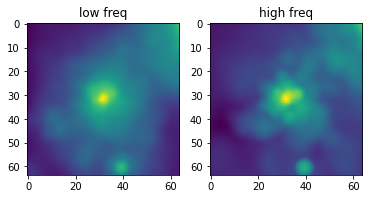

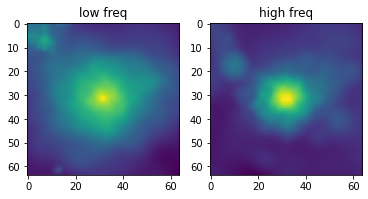

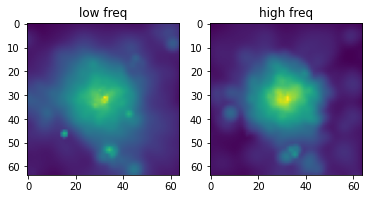

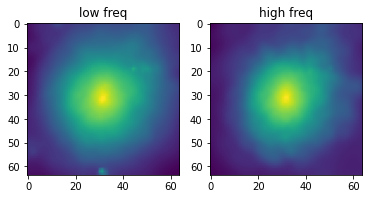

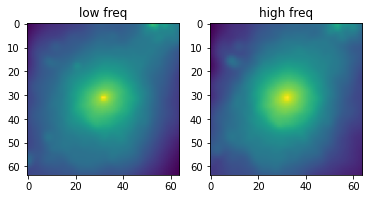

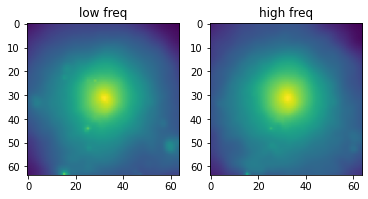

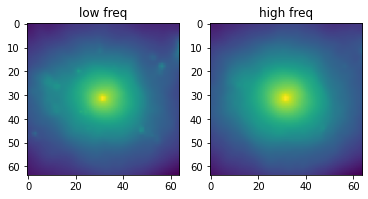

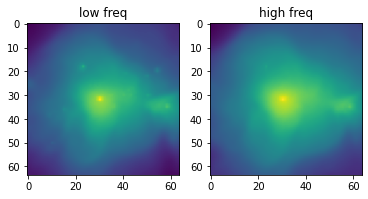

In [49]:
mass_sort = np.argsort(masses)
for i in mass_sort[1::50]:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(np.log10(images[i,0,:,:]))
    axs[0].set_title("low freq")
    axs[1].imshow(np.log10(images[i,1,:,:]))
    axs[1].set_title("high freq")
    # plt.title(f"Mass: {np.log10(masses[i]):.01f}")
    plt.show()

# prediction exploration

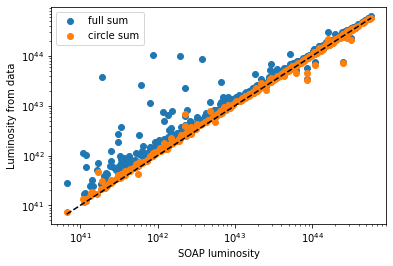

In [39]:
lums = data.soap_file[f"{data.selection_type}/XRayLuminosity"][indices][:int(len(indices)*data.test_size), 0]

pixel_size = 2 * 2000 / 64  #kpc
lums_circle = []
for i, haloindex in enumerate(indices[:int(len(indices)*data.test_size)]):
    r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
    radius = r / pixel_size
    X, Y = np.ogrid[:resolution, :resolution]
    dist_from_center = np.sqrt((X + 0.5-int(resolution/2))**2+(Y+0.5-int(resolution/2))**2)
    mask_outer = dist_from_center<=radius
    lums_circle.append(np.sum(images[i, 0][mask_outer]))

plt.scatter(lums, np.sum(images[:,0,:,:], axis=(1, 2)), label="full sum")
plt.scatter(lums, lums_circle, label="circle sum")
diag = np.linspace(np.min(lums), np.max(lums), 20)
plt.plot(diag, diag, color="black", ls="dashed")
plt.xlabel("SOAP luminosity")
plt.ylabel("Luminosity from data")
# plt.title("Sum over pixels within SORadius")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()



# simulation exploration


In [4]:
soap_path = "halo_properties_0077.hdf5"
data = Data(p)

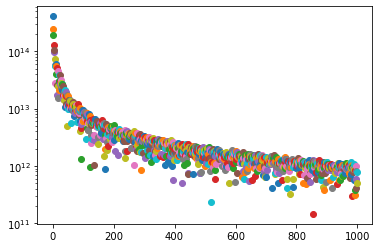

In [8]:
for i, mass in enumerate(data.soap_file[f"{p['selection_type']}/TotalMass"][:10000:10]):
    plt.scatter(i, mass)
plt.yscale("log")
plt.show()

KeyError: 'Unable to synchronously open object (component not found)'

[1.00126345e+11 1.62548522e+11 2.63886813e+11 4.28402849e+11
 6.95483792e+11 1.12907210e+12 1.83297414e+12 2.97571272e+12
 4.83087349e+12 7.84260473e+12 1.27319519e+13 2.06694848e+13
 3.35555464e+13 5.44752181e+13 8.84369263e+13 1.43571521e+14
 2.33078903e+14 3.78388238e+14 6.14288367e+14 9.97256679e+14]


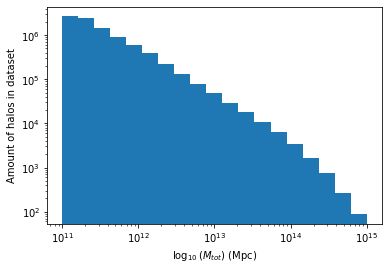

In [23]:
mass = data.soap_file[f"{p['selection_type']}/TotalMass"][:]
mass = mass[np.logical_and(np.logical_and(mass > 1e11, mass !=0), mass < 1e15)]
bins = np.logspace(np.log10(np.min(mass)), np.log10(np.max(mass)), 20)
print(bins)
ret = plt.hist(mass, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Amount of halos in dataset")
plt.xlabel("$\log_{10}(M_{tot})$ (Mpc)")
plt.show()

In [24]:
print(ret)

(array([2.658175e+06, 2.436279e+06, 1.443613e+06, 8.889650e+05,
       5.937730e+05, 3.860400e+05, 2.274540e+05, 1.318370e+05,
       7.770900e+04, 4.786600e+04, 2.939100e+04, 1.817200e+04,
       1.072000e+04, 6.328000e+03, 3.430000e+03, 1.670000e+03,
       7.550000e+02, 2.690000e+02, 8.800000e+01]), array([1.00126345e+11, 1.62548522e+11, 2.63886813e+11, 4.28402849e+11,
       6.95483792e+11, 1.12907210e+12, 1.83297414e+12, 2.97571272e+12,
       4.83087349e+12, 7.84260473e+12, 1.27319519e+13, 2.06694848e+13,
       3.35555464e+13, 5.44752181e+13, 8.84369263e+13, 1.43571521e+14,
       2.33078903e+14, 3.78388238e+14, 6.14288367e+14, 9.97256679e+14]), <BarContainer object of 19 artists>)
